In [1]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm

# Instacart recommendations

### Looking for exploitable trends in the data


### Data Definition

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


# Load data

In [2]:
%matplotlib inline

In [3]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [4]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [5]:
# aliases for easy typing & set index columns
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

#### Build (flat) order details table:

In [6]:
ops.columns, orders.columns, products.columns

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object'),
 Index(['user_id', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order'],
       dtype='object'),
 Index(['product_name', 'aisle_id', 'department_id'], dtype='object'))

In [7]:
# merge order_products with product info and order info

order_details = pd.merge(ops, orders, left_on='order_id', right_index=True)
order_details = pd.merge(order_details, products, left_on='product_id', right_index=True)
order_details.head()

order_id  product_id  add_to_cart_order  reordered  user_id  \
0            2       33120                  1          1   202279   
455        390       33120                 28          1   166654   
1319      1097       33120                 14          1    30502   
2201      1887       33120                  6          1    25085   
3927      3304       33120                  4          1    42591   

      order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0                3          5                  9                     8.0   
455             48          0                 12                     9.0   
1319             5          4                  0                     8.0   
2201            78          1                 10                     3.0   
3927             4          1                 14                    14.0   

            product_name  aisle_id  department_id  
0     Organic Egg Whites        86             16  
455   Organic Egg Whites        86             16  
1319  Organic Egg Whites        86             16  
2201  Organic Egg Whites        86             16  
3927  Organic Egg Whites        86             16

# Summary

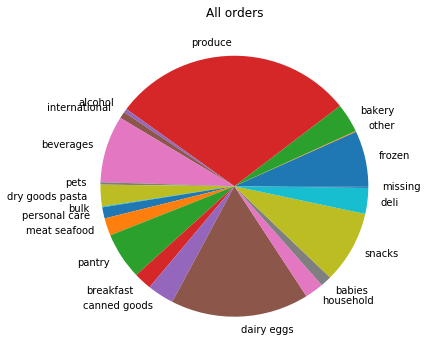

In [83]:
# all orders - department

fig, ax = plt.subplots()

dept_sales = order_details.groupby('department_id').product_id.size()
ax = dept_sales.plot.pie(y='department_id', legend=False, labels=db['departments'].department)
ax.set_ylabel('')
ax.set_title('All orders')
fig.set_size_inches(6, 6)
plt.show()

24 = fresh fruits
83 = fresh vegetables
123 = packaged vegetables fruits
120 = yogurt
21 = packaged cheese
84 = milk
115 = water seltzer sparkling water
107 = chips pretzels
91 = soy lactosefree
112 = bread
31 = refrigerated
116 = frozen produce


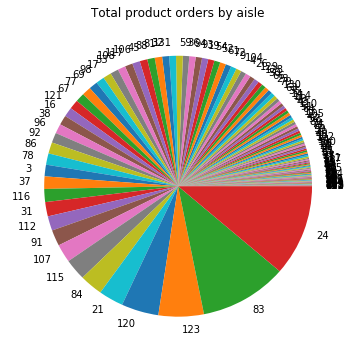

In [86]:
# all orders: aisle

fig, ax = plt.subplots()

aisle_sales = order_details.groupby('aisle_id').size().sort_values()
ax = aisle_sales.plot.pie(y='aisle_id', legend=False)
ax.set_ylabel('')
ax.set_title('Total product orders by aisle')
fig.set_size_inches(6, 6)

for i in range(12):
    which = aisle_sales.index[-1-i]
    print('{} = {}'.format(which, db['aisles'].aisle.loc[which]))

#### Add some features to order_products & orders tables 

In [10]:
# highest order number for each user_id i.e. total_orders_by_user
num_orders = orders.groupby('user_id')['order_number'].max()
num_orders.name = 'total_orders_by_user'

In [15]:
orders['hour_of_week'] = orders.order_dow * 24 + orders.order_hour_of_day
first_order = orders[orders.order_number == 1]
first_order.head(5)

orders = pd.merge(orders, first_order[['hour_of_week', 'user_id']], on='user_id', suffixes=['', '_first_order'])

In [16]:
ops = pd.merge(order_details, first_order[['order_dow', 'order_hour_of_day', 'user_id']], left_on='user_id', right_on='user_id', how='left', suffixes=['', '_first_order'])

In [19]:
ops['hour_of_week'] = ops.order_dow * 24 + ops.order_hour_of_day

In [21]:
# add hour of week columns
ops['hour_of_week_first_order'] = ops.order_dow_first_order * 24 + ops.order_hour_of_day_first_order
orders.columns

Index(['user_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'hour_of_week', 'hour_of_week_first_order'],
      dtype='object')

In [11]:
order_details = pd.merge(order_details, pd.DataFrame(num_orders), left_on='user_id', right_index=True)

#### Question:
# Is the time of an order predictive of order size?

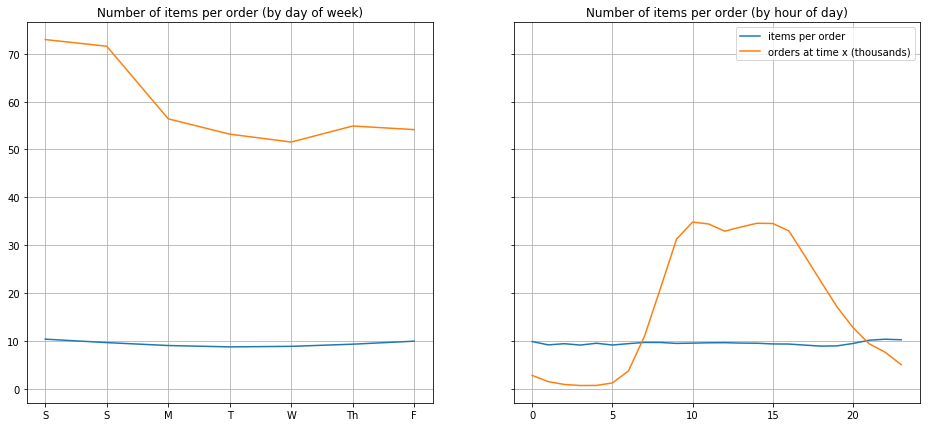

In [121]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 7)

# day of week
ax[0].plot(ops.groupby('order_dow').size() / orders.groupby('order_dow').size())
ax[0].set_title('Number of items per order (by day of week)')
ax[0].set_xticklabels(['', 'S', 'S', 'M', 'T', 'W', 'Th', 'F'])

ax[0].plot(orders.groupby('order_dow').size() / 1000)

plt.legend(['items per order', 'orders at time (thousands)'])
ax[0].grid(True)

# hour of day
ax[1].plot(ops.groupby('order_hour_of_day').size() / orders.groupby('order_hour_of_day').size())
ax[1].set_title('Number of items per order (by hour of day)')
ax[1].grid(True)

ax[1].plot(orders.groupby('order_hour_of_day').size() / 1000)

plt.legend(['items per order', 'orders at time x (thousands)'])
plt.show()

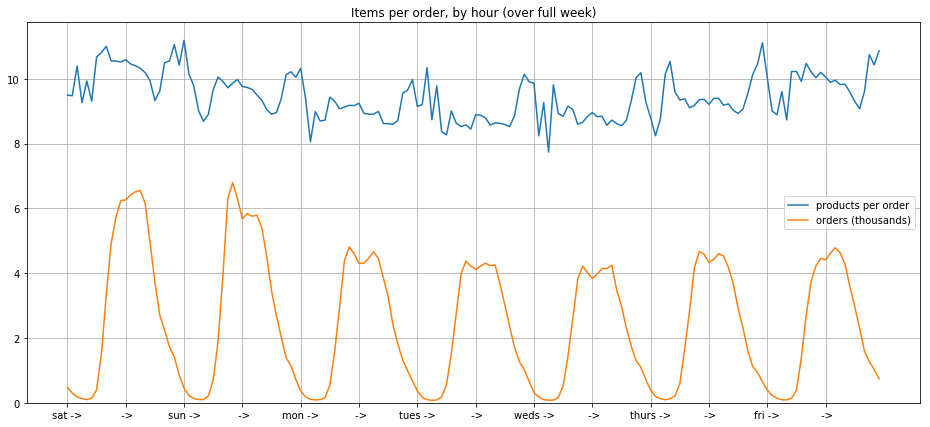

In [70]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(16, 7)

products_by_time = ops.groupby('hour_of_week').size()
orders_by_time = orders.groupby('hour_of_week').size()

ax.plot(products_by_time / orders_by_time)
ax.set_title('Items per order, by hour (over full week)')
ax.set_xticks([12 * i for i in range(14)])
ax.set_xticklabels([day + ' ->' for day in ['sat', '', 'sun', '', 'mon', '', 'tues', '', 'weds', '', 'thurs', '', 'fri', '']])

ax.plot(orders_by_time / 1000)
ax.grid(True)
ax.set_ybound(0)

ax.legend(['products per order', 'orders (thousands)'])
plt.show()

#### Conclusion:
# time as a predictor of order value

The mean size of orders is almost constant with respect to time. Apparent spikes and valleys appear to be products of volatility due to small sample size at off-hours.


#### Question:
# Is customer early order size a predictor of customer retention/value?

i.e. can we start to evaluate LTV for a customer based on their first few orders? If so, what interventions could be made based on that information?

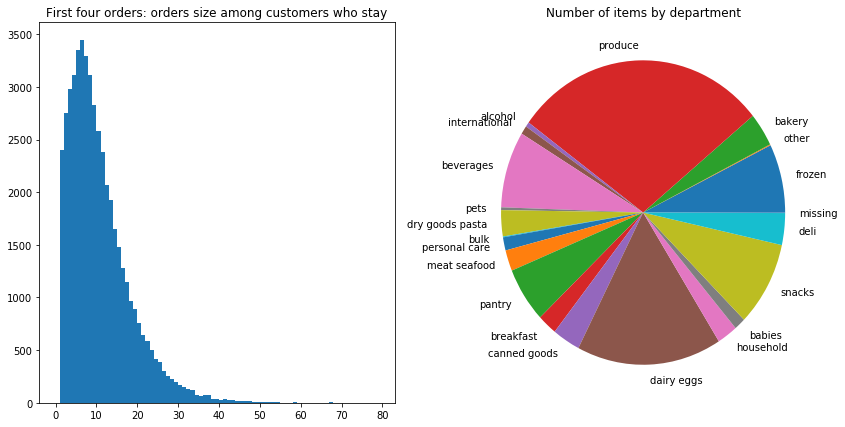

In [12]:
# early orders from long-term customers only ( > 10 orders)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(14, 7)

ax[0].hist(order_details[(order_details.total_orders_by_user > 10) & (order_details.order_number < 5)].groupby('order_id').size(), bins=range(80))
ax[0].set_title('First four orders: orders size among customers who stay')

ax[1] = (order_details[(order_details.total_orders_by_user > 10) & (order_details.order_number < 5)]
         .groupby('department_id').size()
         .plot.pie(y='department_id',
                   legend=False,
                   labels=db['departments'].department))
ax[1].set_ylabel('')
ax[1].set_title('Number of items by department')

plt.show()

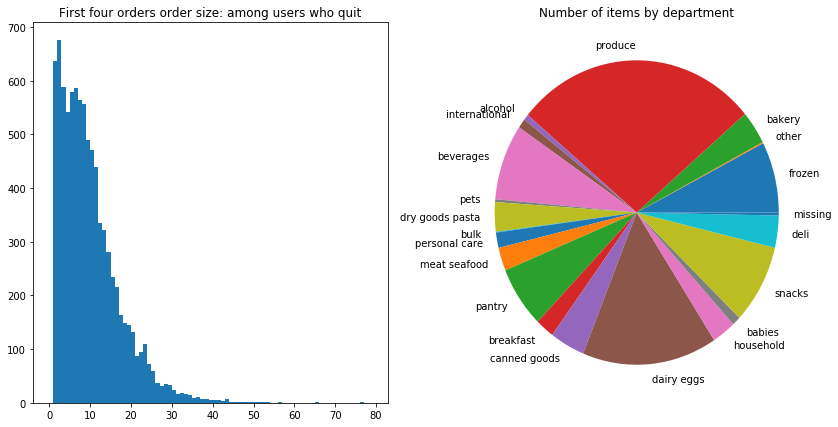

In [13]:
# early orders from short-term customers only (4 orders)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(14, 7)

ax[0].hist(order_details[(order_details.total_orders_by_user < 5) & (order_details.order_number < 5)].groupby('order_id').size(), bins=range(80))
ax[0].set_title('First four orders order size: among users who quit')

ax[1] = (order_details[(order_details.total_orders_by_user < 5) & (order_details.order_number < 5)]
         .groupby('department_id').size()
         .plot.pie(y='department_id',
                   legend=False,
                   labels=db['departments'].department))
ax[1].set_ylabel('')
ax[1].set_title('Number of items by department')

plt.show()

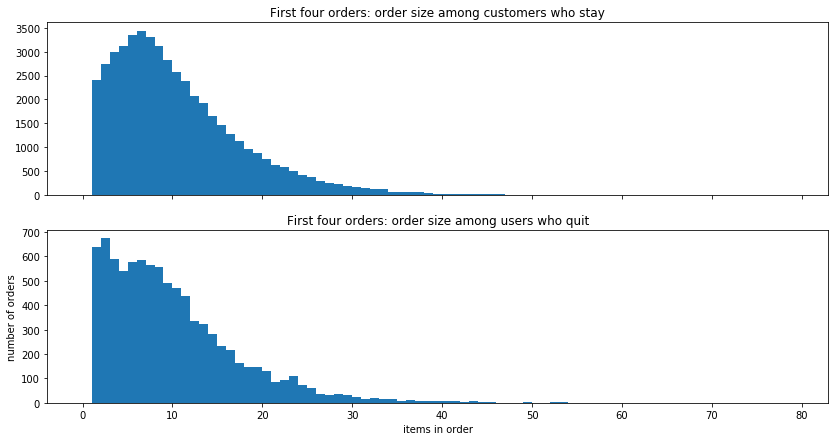

In [60]:
# early orders from long-term customers only ( > 10 orders)

fig, ax = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(14, 7)

ax[0].hist(order_details[(order_details.total_orders_by_user > 10) & (order_details.order_number < 5)].groupby('order_id').size(), bins=range(80))
ax[0].set_title('First four orders: order size among customers who stay')
plt.xlabel('items in order')
plt.ylabel('number of orders')

ax[1].hist(order_details[(order_details.total_orders_by_user < 5) & (order_details.order_number < 5)].groupby('order_id').size(), bins=range(80))
ax[1].set_title('First four orders: order size among users who quit')


plt.show()

In [14]:
# there is a correlation between small initial order size and churn; what would the value of this data be?

cutoff = 2  # minimum number of products in a 'small' order

short = order_details[(order_details.total_orders_by_user < 5) & 
                      (order_details.order_number < 5)].groupby('order_id').size()
long = order_details[(order_details.total_orders_by_user > 10) & 
                     (order_details.order_number < 5)].groupby('order_id').size()

small_orders = 0
for order in short:
    if order <= cutoff:
        small_orders += 1
        
print('     % small first orders for short-term customers: {:f}'.format(small_orders/len(short)))
print('number small first orders for short-term customers: {}'.format(small_orders))


small_orders = 0
for order in long:
    if order <= cutoff:
        small_orders += 1
        
print('    % small first orders for long-term customers:  {:f}'.format(small_orders/len(long)))
print('number small first orders for long-term customers: {}'.format(small_orders))


     % small first orders for short-term customers: 0.148500
number small first orders for short-term customers: 1312
    % small first orders for long-term customers:  0.104965
number small first orders for long-term customers: 5150


#### Conclusion:
# Early order size as predictor of retention

### Customers who will make < 5 orders on Instacart are more likely to have small early order size.

However, among users with very small initial orders, many will still continue using the servoce. This group is not specific enough to be purely  to addressing this group. And overall, the distribution of products purchased by short-term users is very similar to that of long-term users.

Issues with 
- Data has been filtered to exclude users with less than 4 orders (so effect may be stronger than what we can see here)
- This dataset does not specify whether information for a user is their complete order history (i.e. some users with 4 total orders may still be active)

### Potential actions:
Offer discounts to users with small order sizes to incentivize increasing how much they buy.

e.g. for a user with 2 items in cart, third order, has made two small orders:
### Add one more unique item, get 10% off today's purchase!

#### Question:
# Is time of first order a predictor of customer value?

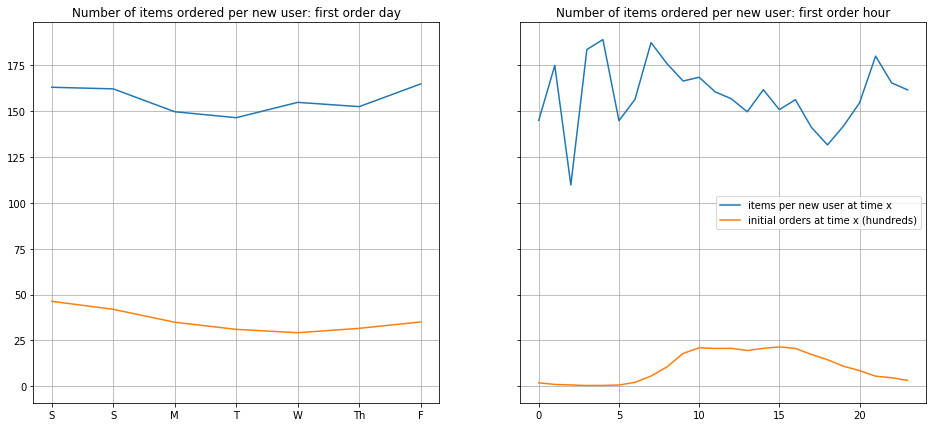

In [42]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 7)

# day of week
ax[0].plot(ops.groupby('order_dow_first_order').size() / first_order.groupby('order_dow').size())
ax[0].set_title('Number of items ordered per new user: first order day')
ax[0].set_xticklabels(['', 'S', 'S', 'M', 'T', 'W', 'Th', 'F'])
ax[0].grid(True)

ax[0].plot(orders[orders.order_number == 1].groupby('order_dow').size() / 100)

# hour of day
ax[1].plot(ops.groupby('order_hour_of_day_first_order').size() / first_order.groupby('order_hour_of_day').size())
ax[1].set_title('Number of items ordered per new user: first order hour')
ax[1].grid(True)

ax[1].plot(orders[orders.order_number == 1].groupby('order_hour_of_day').size() / 100)

plt.legend(['items per new user at time x', 'initial orders at time x (hundreds)'])
plt.show()

### Time distribution across entire week

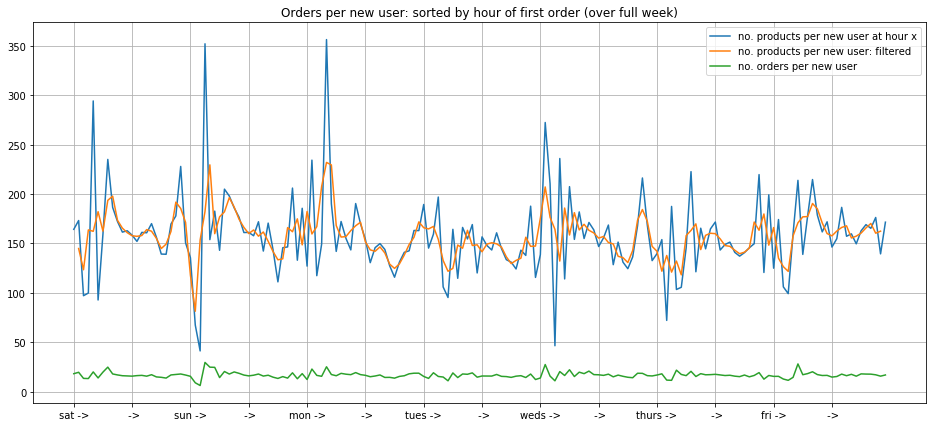

In [78]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(16, 7)

products_by_first_order = ops.groupby('hour_of_week_first_order').size() / first_order.groupby('hour_of_week').size()

ax.plot(products_by_first_order)
ax.set_title('Orders per new user: sorted by hour of first order (over full week)')
ax.set_xticks([12 * i for i in range(14)])
ax.set_xticklabels([day + ' ->' for day in ['sat', '', 'sun', '', 'mon', '', 'tues', '', 'weds', '', 'thurs', '', 'fri', '']])

ax.plot(products_by_first_order.rolling(window=3, center=True).mean())
ax.grid(True)
ax.set_ybound(0)

ax.plot(orders.groupby('hour_of_week_first_order').size() / first_order.groupby('hour_of_week').size())

ax.legend(['no. products per new user at hour x',
           'no. products per new user: filtered',
           'no. orders per new user',
           'sample size'])
plt.show()

In [53]:
first_order[(first_order.hour_of_week < 29) & (first_order.hour_of_week > 26)]

user_id  order_number  order_dow  order_hour_of_day  \
order_id                                                        
2955606       160             1          1                  3   
1331287      7745             1          1                  4   
1833568     25124             1          1                  4   
2231239     46417             1          1                  4   
71307       59145             1          1                  3   
2562451     77303             1          1                  3   
2367774     80500             1          1                  4   
5609        91027             1          1                  3   
981616      93513             1          1                  4   
891340      93636             1          1                  4   
2428725     94933             1          1                  3   
3201456    120424             1          1                  4   
2834160    143031             1          1                  4   
2422100    144148             1          1                  3   
2712045    154282             1          1                  3   
2708542    166731             1          1                  3   
1799886    167648             1          1                  4   
735060     183477             1          1                  4   
350185     192524             1          1                  4   

          days_since_prior_order  hour_of_week  
order_id                                        
2955606                      NaN            27  
1331287                      NaN            28  
1833568                      NaN            28  
2231239                      NaN            28  
71307                        NaN            27  
2562451                      NaN            27  
2367774                      NaN            28  
5609                         NaN            27  
981616                       NaN            28  
891340                       NaN            28  
2428725                      NaN            27  
3201456                      NaN            28  
2834160                      NaN            28  
2422100                      NaN            27  
2712045                      NaN            27  
2708542                      NaN            27  
1799886                      NaN            28  
735060                       NaN            28  
350185                       NaN            28

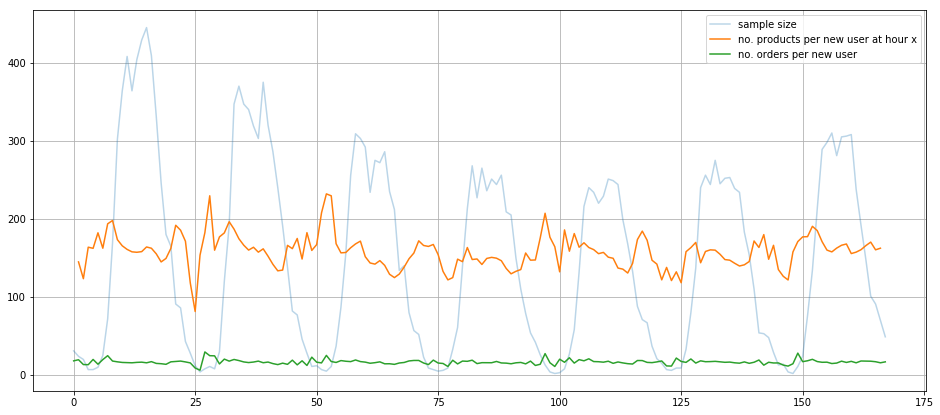

In [80]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(16, 7)

products_by_first_order = ops.groupby('hour_of_week_first_order').size() / first_order.groupby('hour_of_week').size()


ax.plot(first_order.groupby('hour_of_week').size(), alpha=.3)


ax.plot(products_by_first_order.rolling(window=3, center=True).mean())
ax.grid(True)
ax.set_ybound(0)

ax.plot(orders.groupby('hour_of_week_first_order').size() / first_order.groupby('hour_of_week').size())

ax.legend(['sample size',
           'no. products per new user at hour x',
           'no. orders per new user',
           ])
plt.show()

In [81]:
# sanity check - number of items / number of users
print('items/user:', len(ops) / len(first_order))
# sanity check 2 - number of orders / number of users
print('orders/user:', len(orders) / len(first_order))

items/user: 156.95152
orders/user: 16.59088


#### Conclusion: 
# time of first order

Time of first order does correlate with customer LTV. However, even with this large dataset, there are not enough orders at high-volatility times to take the details of this trend at face value.

Customers who make their first order on a weekend purchase, on average, about 15% more than customers who make their first purchase M-Th.

Ads for customer acquisition should be tuned to reflect the projected value of customers at those times.

#### Question:
# What percent of orders for product categories are reorders?

If a product is never reordered or negatively affects customer retrention, this is a problem (that is easy to solve).

What categories over/under perform for reorders?

In [87]:
tmp = pd.DataFrame({'reorder_pct': ops.groupby('product_id').reordered.mean(),
                    'num_orders': order_details.groupby('product_id').size()})

In [88]:
order_details = pd.merge(order_details, tmp, left_on='product_id', right_index=True)

In [89]:
order_details.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'total_orders_by_user', 'num_orders', 'reorder_pct'],
      dtype='object')

In [110]:
reos = order_details.groupby('department_id').reorder_pct.mean().sort_values()
dept_orders = order_details.groupby('department_id').size()
for i in range(len(reos)):
    dept = reos.index[i]
    print('{:<2} - {:<16} reorder %: {:0.2f}     Dept size: {:d}'.format(dept, db['departments'].department.loc[dept], reos[dept], dept_orders[dept]))

11 - personal care    reorder %: 0.32     Dept size: 54319
13 - pantry           reorder %: 0.35     Dept size: 226518
6  - international    reorder %: 0.38     Dept size: 32702
2  - other            reorder %: 0.40     Dept size: 4226
21 - missing          reorder %: 0.40     Dept size: 8253
17 - household        reorder %: 0.40     Dept size: 89142
15 - canned goods     reorder %: 0.45     Dept size: 127249
9  - dry goods pasta  reorder %: 0.46     Dept size: 105315
1  - frozen           reorder %: 0.54     Dept size: 269145
14 - breakfast        reorder %: 0.55     Dept size: 85102
10 - bulk             reorder %: 0.56     Dept size: 4013
12 - meat seafood     reorder %: 0.56     Dept size: 84813
19 - snacks           reorder %: 0.57     Dept size: 349751
5  - alcohol          reorder %: 0.58     Dept size: 18182
18 - babies           reorder %: 0.59     Dept size: 53448
8  - pets             reorder %: 0.60     Dept size: 11550
20 - deli             reorder %: 0.60     Dept size: 1

department    personal care
Name: 11, dtype: object


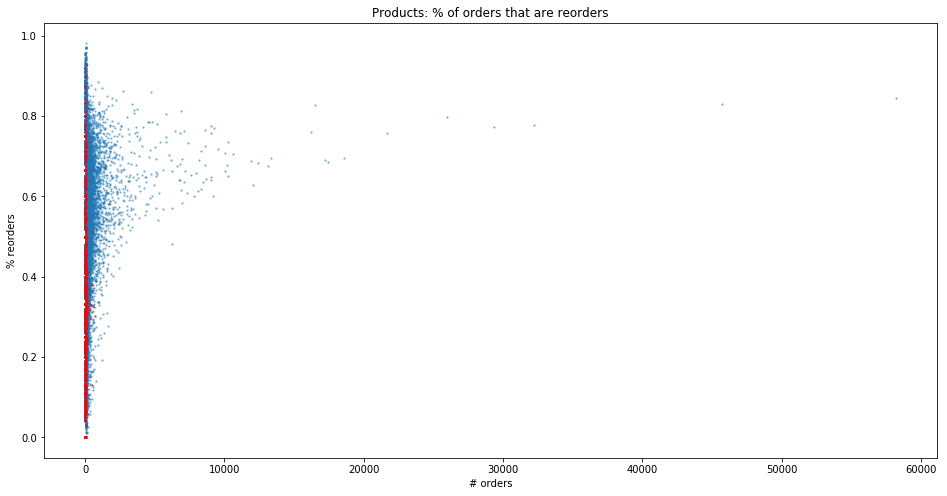

In [114]:
# plot percentage reorders by department
fig, ax = plt.subplots()
dept_id = 11

print(db['departments'].loc[dept_id])

fig.set_size_inches(16,8)
ax.scatter(order_details.groupby('product_id').size(), 
           order_details.groupby('product_id').reorder_pct.mean(),
           s=2,
           alpha=.4,)

ax.scatter(order_details[order_details.department_id == dept_id].groupby('product_id').size(), 
           order_details[order_details.department_id == dept_id].groupby('product_id').reorder_pct.mean(),
           s=1,
           color='red',
           alpha=.6,)

ax.set_xlabel('# orders')
ax.set_ylabel('% reorders')
ax.set_title('Products: % of orders that are reorders')
plt.show()

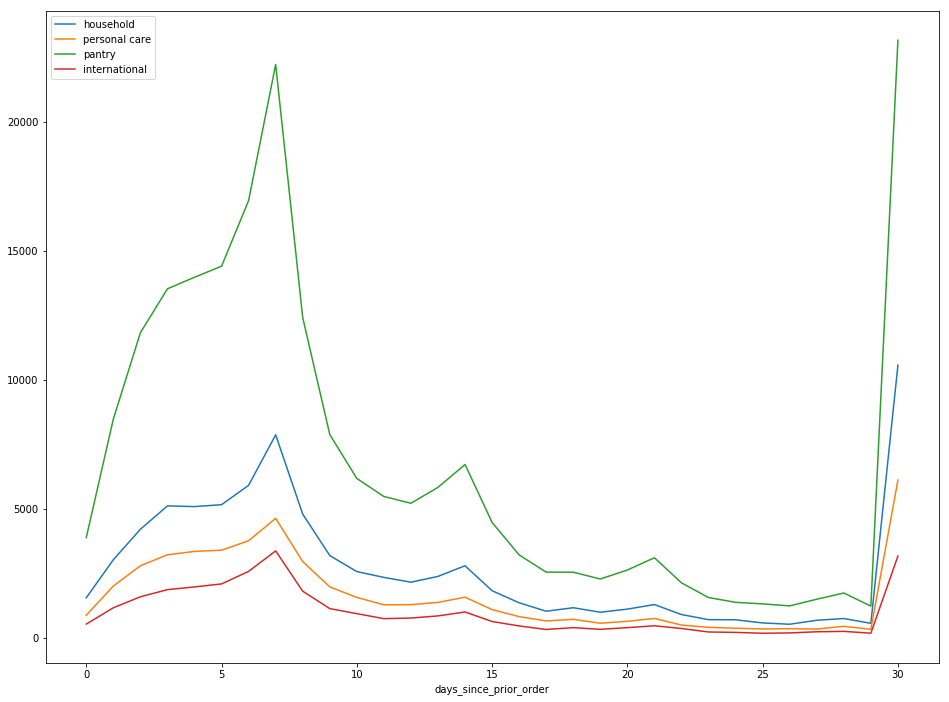

In [128]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)

for i in [17, 11, 13, 6]:
    series = order_details[order_details.department_id == i].groupby('days_since_prior_order').size()
    (series).plot(label=db['departments'].department.loc[i],)
    # (series/series.max()).plot(label=db['departments'].department.loc[i],)
    
ax.legend()

In [120]:
products[products.product_name.str.lower().str.contains('soap')].head()

product_name  aisle_id  \
product_id                                                          
152         3 in 1 Soap for Every Man, Cucumber & Lemon        25   
224                    Foaming Hand Soap Kid Watermelon       114   
320          Glycerine Soap, Pure and Natural, Cucumber        25   
333                                 Basil Daly Bar Soap        25   
337          Soap, Pure-Castile, 18-in-1 Hemp, Lavender        25   

            department_id  
product_id                 
152                    11  
224                    17  
320                    11  
333                    11  
337                    11

#### conclusion:

# Reorder rate

- Reorders generally correlate with our intuition about 'how fast products are used up'.
- Reorders are lowest on:
1. Pantry foods
2. International foods
3. Peronal care items
4. Household items

The last two of these, Personal care and household goods, present an obvious opportunity to increase reorders. Both of these categories may be relatively infrequent purchases, but it is unlikely that customers are changing their habits on these types of products. Further, personal care products especially should have a highly periodic purchase cycle.

# Time

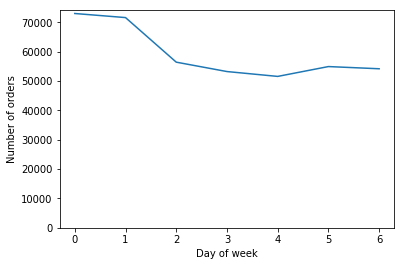

In [134]:
ax = orders.groupby('order_dow').size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')
plt.show()

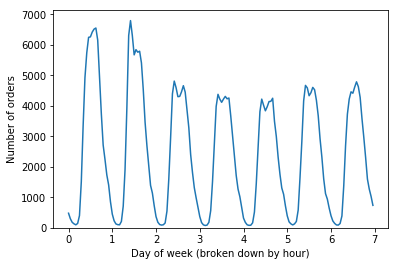

In [135]:
ax = orders.groupby(['order_dow', 'order_hour_of_day']).size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week (broken down by hour)')
ax.set_xticks([24 * i for i in range(8)])
ax.set_xticklabels(range(8))
plt.show()

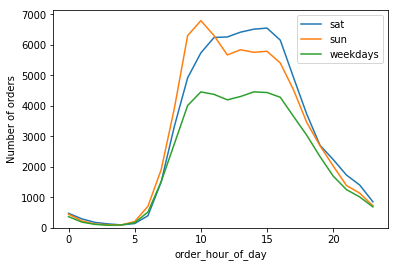

In [136]:
ax = (orders[orders.order_dow == 0].groupby('order_hour_of_day').size()).plot(label='sat')
ax = (orders[orders.order_dow == 1].groupby('order_hour_of_day').size()).plot(label='sun')
ax.set_ylabel('Number of orders')
ax.set_xlabel('hour')

ax = (orders[orders.order_dow.isin([2,3,4,5,6])].groupby('order_hour_of_day').size()/5).plot(label='weekdays')
ax.set_ybound(0)
ax.legend()
plt.show()

### Interesting features of time distribution: 

- weekday lunch trough
- first two days must be Sat/Sun? 5 vs. 2

# product time groups:

Do products vary significantly in terms of:
- order time
- cart add order


Make a column for cart add order: order_position_pct

In [137]:
tmp = pd.DataFrame({'order_size': order_details.groupby('order_id').size()})   # number of items in an order

In [138]:
order_details = pd.merge(order_details, tmp, left_on='order_id', right_index=True)

In [139]:
order_details['order_position_pct'] = order_details.add_to_cart_order / order_details.order_size

In [140]:
order_details.head()

order_id  product_id  add_to_cart_order  reordered  user_id  order_number  \
0         2       33120                  1          1   202279             3   
1         2       28985                  2          1   202279             3   
2         2        9327                  3          0   202279             3   
3         2       45918                  4          1   202279             3   
4         2       30035                  5          0   202279             3   

   order_dow  order_hour_of_day  days_since_prior_order  \
0          5                  9                     8.0   
1          5                  9                     8.0   
2          5                  9                     8.0   
3          5                  9                     8.0   
4          5                  9                     8.0   

            product_name  aisle_id  department_id  total_orders_by_user  \
0     Organic Egg Whites        86             16                     9   
1  Michigan Organic Kale        83              4                     9   
2          Garlic Powder       104             13                     9   
3         Coconut Butter        19             13                     9   
4      Natural Sweetener        17             13                     9   

   num_orders  reorder_pct  order_size  order_position_pct  
0        2506     0.723464           9            0.111111  
1        8192     0.691650           9            0.222222  
2         774     0.139535           9            0.333333  
3          98     0.306122           9            0.444444  
4          34     0.352941           9            0.555556

In [141]:
cart_adds = order_details[order_details.num_orders >= 1000].groupby('product_id')['order_position_pct'].mean().sort_values()
cart_adds[:10]

product_id
39180    0.372177
45504    0.377191
43394    0.378304
38689    0.390259
29447    0.394541
24852    0.398687
13166    0.401335
24024    0.404682
1463     0.414550
1511     0.414968
Name: order_position_pct, dtype: float64

In [142]:
products.loc[cart_adds.index[-10:].values]   # 10 latest-added products

product_name  aisle_id  department_id
product_id                                                         
32691                    Vanilla Ice Cream        37              1
7503                         Whole Almonds       117             19
31066                        Aluminum Foil        85             17
13535                 Organic Medium Salsa        51             13
44628                Organic Dijon Mustard        72             13
24009        Organic Long Grain White Rice        63              9
5068                   Cauliflower Florets        32              4
46149                    Zero Calorie Cola        77              7
21195       Organic Extra Virgin Olive Oil        19             13
40199               Chocolate Chip Cookies        61             19

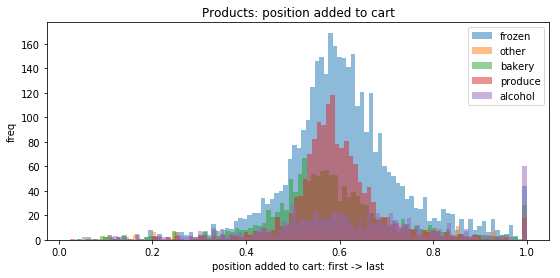

In [143]:
# plot cart order add position by dept
fig, ax = plt.subplots()
dept_id = 11


fig.set_size_inches(9,4)

for i in range(1, 6):
    l = db['departments'].loc[i]
    hf = order_details[order_details.department_id == i].groupby('product_id')['order_position_pct'].mean()
    ax.hist(hf,
            alpha=.5,
            bins=100,
            label=l,)

ax.set_xlabel('position added to cart: first -> last')
ax.set_ylabel('freq')
ax.set_title('Products: position added to cart')
plt.legend()
plt.show()

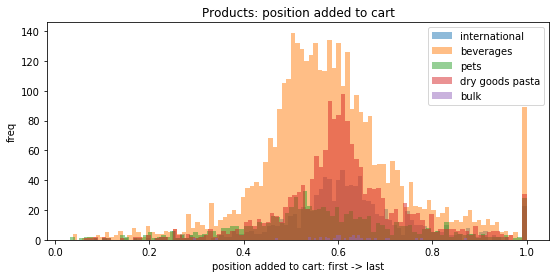

In [144]:
# plot cart order add position by dept
fig, ax = plt.subplots()
dept_id = 11


fig.set_size_inches(9,4)

for i in range(6, 11):
    l = db['departments'].loc[i]
    hf = order_details[order_details.department_id == i].groupby('product_id')['order_position_pct'].mean()
    ax.hist(hf,
            alpha=.5,
            bins=100,
            label=l,)

ax.set_xlabel('position added to cart: first -> last')
ax.set_ylabel('freq')
ax.set_title('Products: position added to cart')
plt.legend()
plt.show()

# lesson of cart_add_order: 

People put junk food, booze, etc. in their cart at the end. If we know/suspect a shopper is almost done shopping, it could be an opportunity to add on guilty-pleasure type products.

# opposite: what products get added first?

In [145]:
products.loc[cart_adds.index[:10].values]   # 10 first added products

product_name  aisle_id  \
product_id                                                          
39180                            Organic Lowfat 1% Milk        84   
45504                        Whole Organic Omega 3 Milk        84   
43394                   Organic Lactose Free Whole Milk        91   
38689                          Organic Reduced Fat Milk        84   
29447                          Milk, Organic, Vitamin D        84   
24852                                            Banana        24   
13166              Organic Milk Reduced Fat, 2% Milkfat        84   
24024                                    1% Lowfat Milk        84   
1463                                       Organic Milk        84   
1511        2% Reduced Fat DHA Omega-3 Reduced Fat Milk        84   

            department_id  
product_id                 
39180                  16  
45504                  16  
43394                  16  
38689                  16  
29447                  16  
24852                   4  
13166                  16  
24024                  16  
1463                   16  
1511                   16

In [146]:
order_details = pd.merge(order_details, 
                pd.DataFrame({'times_added_first': order_details[order_details.add_to_cart_order == 1].groupby('product_id').size()}),
                right_index=True,
                left_on='product_id')

In [147]:
order_details['pct_added_first'] = order_details.times_added_first / order_details.num_orders

# Reorder time series

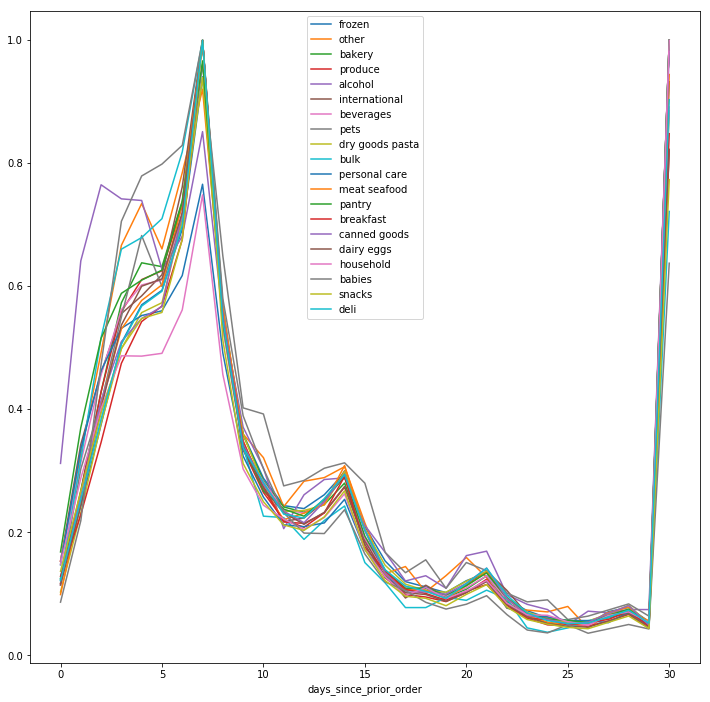

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 21):
    series = order_details[order_details.department_id == i].groupby('days_since_prior_order').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

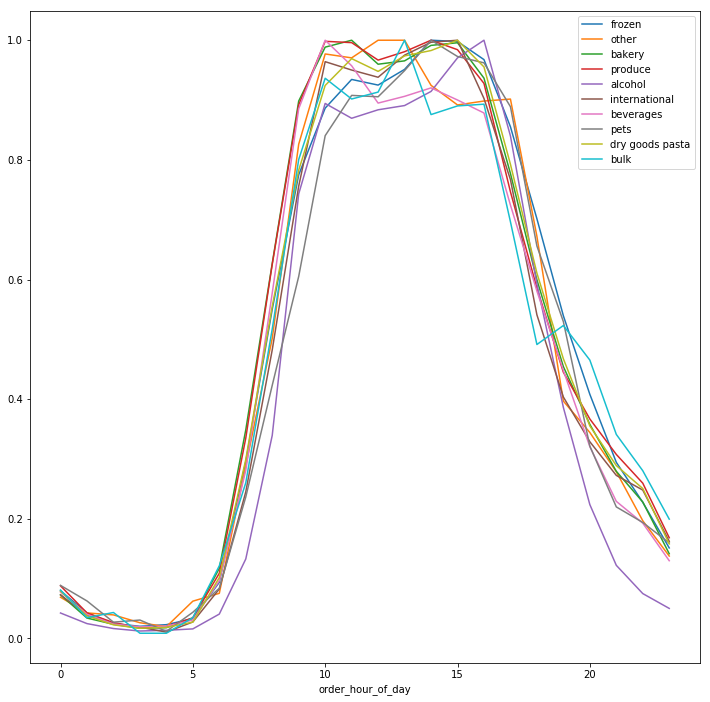

In [149]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

In [150]:
order_details.groupby('aisle_id')['order_hour_of_day'].mean().sort_values()[:10]

aisle_id
125    12.884017
46     12.944597
11     13.015354
32     13.017249
10     13.053254
94     13.067535
53     13.116648
48     13.144849
3      13.178816
114    13.202624
Name: order_hour_of_day, dtype: float64

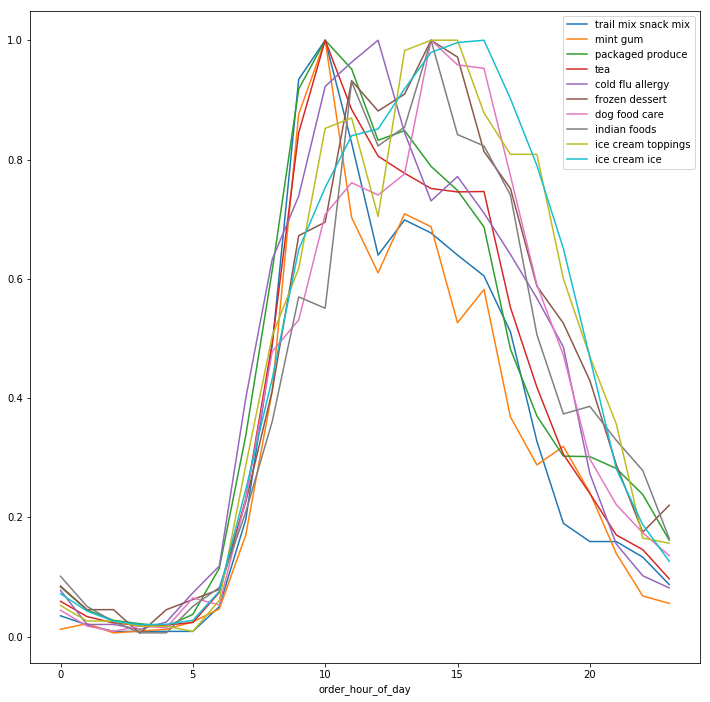

In [151]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in [125, 46, 32, 94, 11, 119, 40, 76, 103, 37]:
    series = order_details[order_details.aisle_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['aisles'].aisle.loc[i])

ax.legend()
plt.show()
# earliest vs. latest product

In [153]:
ops.groupby('product_id').size().sort_values(ascending=False)

order_id  product_id  add_to_cart_order  reordered  user_id  \
0               2       33120                  1          1   202279   
1          104690       33120                  2          1   202279   
2          132412       33120                  1          1   202279   
3         2808715       33120                  1          1   202279   
4         2894949       33120                  5          0   202279   
5               2       28985                  2          1   202279   
6          132412       28985                  7          1   202279   
7         1500071       28985                  1          1   202279   
8         2808715       28985                  2          1   202279   
9         2894949       28985                  4          0   202279   
10              2        9327                  3          0   202279   
11              2       45918                  4          1   202279   
12         132412       45918                  4          1   202279   
13        1500071       45918                  6          0   202279   
14        2382766       45918                  3          1   202279   
15        2808715       45918                  7          1   202279   
16              2       30035                  5          0   202279   
17        2382766       30035                  4          1   202279   
18        2808715       30035                  5          1   202279   
19              2       17794                  6          1   202279   
20         132412       17794                  5          1   202279   
21        1500071       17794                  4          1   202279   
22        2382766       17794                  2          1   202279   
23        2808715       17794                  4          1   202279   
24        2894949       17794                  3          0   202279   
25        3058248       17794                  1          1   202279   
26              2       40141                  7          1   202279   
27         132412       40141                  6          1   202279   
28        1500071       40141                  7          0   202279   
29        2808715       40141                  6          1   202279   
...           ...         ...                ...        ...      ...   
3923758   2571208        7588                  1          0    39049   
3923759   2875482        7053                  2          0    39049   
3923760    451607       12640                  1          1   147588   
3923761   1262486       12640                  1          0   147588   
3923762   2870498       12640                  1          1   147588   
3923763   3083361       12640                  1          1   147588   
3923764    200715        1716                  1          0     2625   
3923765    498414       44950                  2          0     2625   
3923766    200715       44857                  2          1     2625   
3923767    498414       44857                  1          0     2625   
3923768    834127       44857                  2          1     2625   
3923769    834127       46289                  1          0     2625   
3923770    508693        6729                  1          1    54429   
3923771   1191455        6729                  1          0    54429   
3923772   1709566        6729                  1          1    54429   
3923773   1891977        6729                  1          1    54429   
3923774   2233230        6729                  1          1    54429   
3923775   2416605        6729                  1          1    54429   
3923776   2833452        6729                  1          1    54429   
3923777   2953168        6729                  1          1    54429   
3923778    696522       19219                  1          0    54429   
3923779    531005       29659                  1          0   148034   
3923780    394382        5019                  1          0   148034   
3923781    394382       23425                  2 